https://medium.com/geekculture/xgboost-versus-random-forest-898e42870f30

https://towardsdatascience.com/time-series-forecasting-with-machine-learning-b3072a5b44ba

https://lightgbm.readthedocs.io/en/latest/Parameters.html

https://analyticsindiamag.com/deep-learning-xgboost-or-both-what-works-best-for-tabular-data/ and https://arxiv.org/abs/2207.08815

Gradient Boosting 
- Boosting: Boosting is an ensemble learning technique where multiple weak learners (usually decision trees) are combined to create a strong learner. The weak learners are trained sequentially, with each one focusing on the mistakes of its predecessors. 
- Boosting happens to be iterative learning which means the model will predict something initially and self analyses its mistakes as a predictive toiler and give more weightage to the data points in which it made a wrong prediction in the next iteration
-  Gradient Boosting is a specific variant of boosting that uses gradients  (the gradient of the loss function) to optimize the model's performance
- Gradient descent is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function (different types of loss functions can be used)

The LightGBM Regressor:
- ML model that can predict numerical values (regression) based on input features. It works by creating a decision tree ensemble in a way that optimizes training speed and memory usage. It leverages gradient-based techniques to efficiently handle large datasets, making it suitable for time series forecasting tasks like predicting energy production or other continuous numeric variables.
- uses a different approach to tree building known as the Gradient-based One-Side Sampling (GOSS) algorithm. It also uses a histogram-based algorithm to bucket feature values, which can lead to faster training times compared to XGBoost. 
-  designed to take advantage of parallelism on both CPUs and GPUs, making it potentially faster in certain scenarios, especially on GPU hardware.

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from IPython.core.magic import register_cell_magic
import black
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm_notebook
import numpy as np
import os
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import weibull_min
from itertools import product
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Image, Table, TableStyle
from reportlab.lib import colors
%matplotlib inline

In [56]:
@register_cell_magic
def blackify(line, cell):
    formatted_code = black.format_str(cell, mode=black.FileMode())
    exec(formatted_code, globals())

In [3]:
file_path_1 = ""
df= pd.read_csv(file_path_1, sep='\t')
df.drop(['WF', 'WT','Index'], axis=1, inplace=True)
#df.head()


In [41]:
def decompose(df, share_type='ActivePower', samples=1008, period=144): #144=1 day #250 samples
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()
    return residual

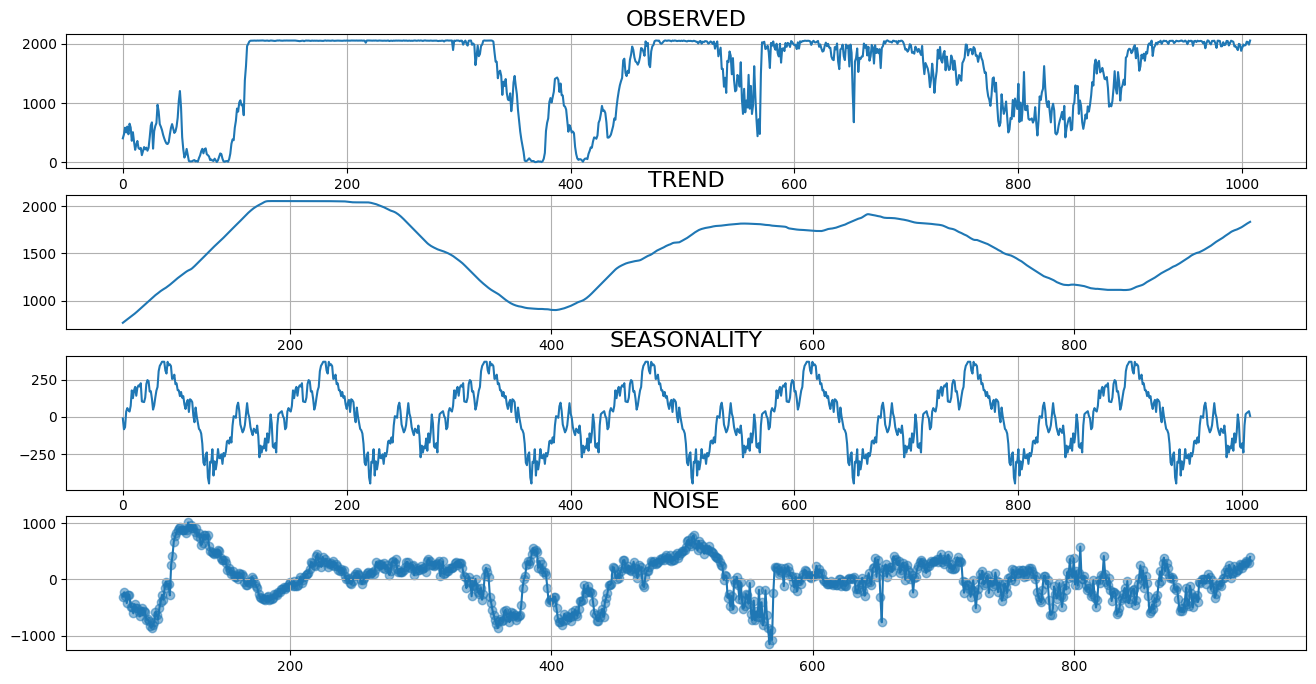

array([nan, nan, nan, ..., nan, nan, nan])

In [42]:
 decompose(df)

- Observed: The original time series data ('ActivePower') with all its fluctuations, trends, and seasonality.
- Trend: The estimated trend component, which represents the long-term underlying pattern or movement in the data.
- Seasonality: The estimated seasonal component, which represents the periodic patterns or variations that occur at regular intervals (in this case, daily seasonality, period=144)
- Noise (Residual): The remaining noise or randomness in the data after removing the trend and seasonal components.

### Autocorrelation

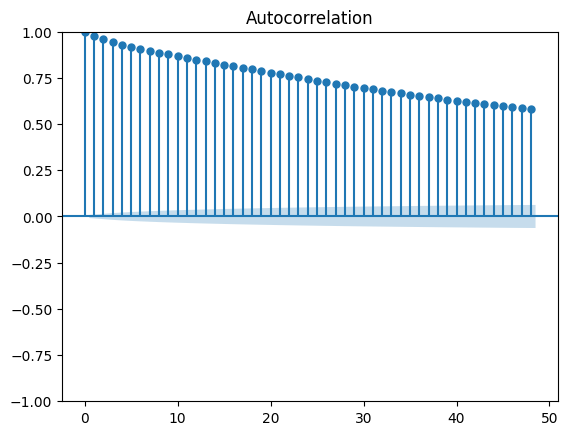

In [24]:
plot_acf(df['ActivePower'].values)
plt.show()

### Stationarity

In [45]:
res = seasonal_decompose(df["ActivePower"].values[-1008:], period=144)
residual=res.resid
residual = residual[~np.isnan(residual)]

In [47]:
def check_stationarity(residuals):
    result = adfuller(residuals)
    p_value = result[1]
    print("ADF p-value:", p_value)
    if p_value <= 0.05:
        print("The residuals are likely stationary.")
    else:
        print("The residuals are likely non-stationary.")

In [49]:
check_stationarity(residual)

ADF p-value: 2.45292695135025e-05
The residuals are likely stationary.


We can reject the null hypothesis, indicating that the data is likely stationary

In [18]:
df['DATE'] = pd.to_datetime(df['DATE'])
#set datetime as index
df = df.set_index(df.DATE)
#drop datetime column
df.drop('DATE', axis=1, inplace=True)
#create hour, day and month variables from datetime index
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df.head()

# Training and Testing 

The following code is not predicting future values; it is predicting ActivePower values for the last part of the dataset (the testing set) using the trained model. The model was trained on past data to predict the corresponding ActivePower values for the testing period. The purpose is to evaluate the model's performance on unseen data to assess how well it can generalize.

The horizon parameter determines the number of time steps into the future for which the model makes predictions.

Which means the model is making predictions for the next 24 time steps (or 240 minutes/4 hours in this case, considering the data has a 10-minute interval).

In [3]:
%%blackify
def train_time_series_with_folds(df, horizon=24):
    X = df.drop('ActivePower', axis=1)
    y = df['ActivePower']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    
    print(f'Mean Absolute Error (MAE): {mae}')
    
    #calculate MSE
    mse = np.round(mean_squared_error(y_test, predictions), 3)
    print(f'Mean Squared Error (MSE): {mse}')
    
    #calculate MAPE
    mape = np.round(np.mean(np.abs((y_test - predictions) / y_test)) * 100, 3)
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('AP', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 54756, number of used features: 4
[LightGBM] [Info] Start training from score 806.763940
Mean Absolute Error (MAE): 724.753
Mean Squared Error (MSE): 707735.067
Mean Absolute Percentage Error (MAPE): 111.068%


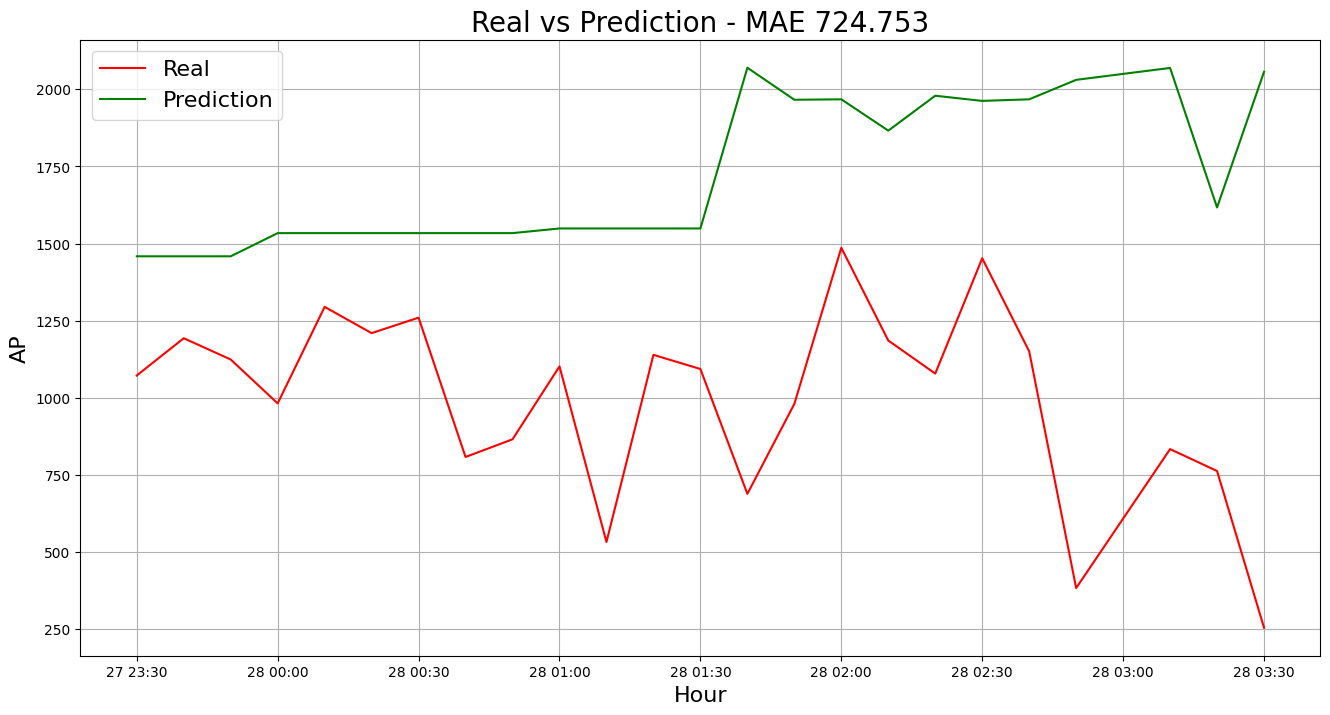

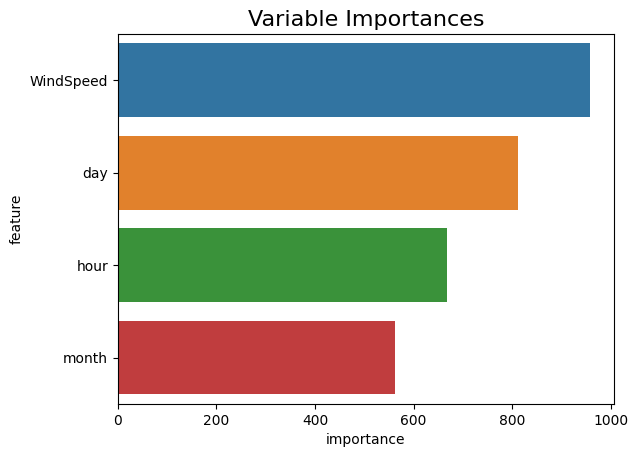

In [14]:
train_time_series_with_folds(df)

# Hyperparameter Tuning of LightGBM

Default parameters of XGBoost:
- num_leaves: 31
- max_depth: -1 (no limit)
- learning_rate: 0.1
- n_estimators: 100
- min_child_samples: 20
- reg_alpha: 0.0

In [5]:
#%%blackify
def hyperparameter_tuning_with_random_search(df, num_iterations, param_search_space, horizon=24):
    X = df.drop('ActivePower', axis=1)
    y = df['ActivePower']
    
    # take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    # Initialize a list to store the results of each iteration
    results = []
    
    for i in range(num_iterations):
        # Sample random hyperparameters from the search space
        params = {param: np.random.choice(values) for param, values in param_search_space.items()}
        
        # Create and train the model with the sampled hyperparameters
        model = LGBMRegressor(random_state=42, **params)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Calculate evaluation metrics (MAE, MSE, MAPE)
        mae = np.round(mean_absolute_error(y_test, predictions), 3)
        mse = np.round(mean_squared_error(y_test, predictions), 3)
        mape = np.round(np.mean(np.abs((y_test - predictions) / y_test)) * 100, 3)
        
        # Store the results of the iteration in the 'results' list
        results.append({'Iteration': i+1, 'Hyperparameters': params, 'MAE': mae, 'MSE': mse, 'MAPE': mape})
        
        # Print the trial number and evaluation metrics before each plot
        print(f"\nTrial {i+1} - MAE: {mae}, MSE: {mse}, MAPE: {mape}%")
        
        # Plot reality vs prediction for the last week of the dataset
        fig = plt.figure(figsize=(16, 8))
        plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
        plt.plot(y_test, color='red', label='Real')
        plt.plot(pd.Series(predictions, index=y_test.index), color='green', label='Prediction')
        plt.xlabel('Hour', fontsize=16)
        plt.ylabel('Number of Shared Bikes', fontsize=16)
        plt.legend(fontsize=16)
        plt.grid()
        plt.show()

    # Sort the results based on the MSE values in ascending order
    sorted_results_mse = sorted(results, key=lambda x: x['MSE'])
    
    # Print the best 5 trials with lower MSE values
    print("\nBest 5 trials based on lower MSE values:")
    for i in range(min(5, num_iterations)):
        print(f"Iteration {sorted_results_mse[i]['Iteration']} - MSE: {sorted_results_mse[i]['MSE']}")
        print(f"Hyperparameters: {sorted_results_mse[i]['Hyperparameters']}")
        print("----------------------------------------------------")

    # Sort the results based on the MAPE values in ascending order
    sorted_results_mape = sorted(results, key=lambda x: x['MAPE'])
    
    # Print the best 5 trials with lower MAPE values
    print("\nBest 5 trials based on lower MAPE values:")
    for i in range(min(5, num_iterations)):
        print(f"Iteration {sorted_results_mape[i]['Iteration']} - MAPE: {sorted_results_mape[i]['MAPE']}%")
        print(f"Hyperparameters: {sorted_results_mape[i]['Hyperparameters']}")
        print("----------------------------------------------------")
    

# Define the parameter search space
param_search_space = {
    'learning_rate': [0.01, 0.001,0.1],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20],
    'num_leaves': [20, 30, 40, 50],
    'min_child_samples': [10, 20, 30, 40],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0]
}

# Assuming you have already loaded and preprocessed the data in 'df'
num_iterations = 1000
#hyperparameter_tuning_with_random_search(df, num_iterations, param_search_space)


Best 5 trials based on lower MSE values:
Iteration 763 - MSE: 101901.974
Hyperparameters: {'learning_rate': 0.001, 'n_estimators': 200, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 10, 'reg_alpha': 0.0}
----------------------------------------------------
Iteration 46 - MSE: 101902.036
Hyperparameters: {'learning_rate': 0.001, 'n_estimators': 200, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 10, 'reg_alpha': 0.1}
----------------------------------------------------
Iteration 465 - MSE: 101902.036
Hyperparameters: {'learning_rate': 0.001, 'n_estimators': 200, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 10, 'reg_alpha': 0.1}
----------------------------------------------------
Iteration 429 - MSE: 101903.157
Hyperparameters: {'learning_rate': 0.001, 'n_estimators': 200, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 10, 'reg_alpha': 0.5}
----------------------------------------------------
Iteration 638 - MSE: 101908.211
Hyperparameters: {'learning_rate': 0.001, 'n_estimators': 200, 'max_depth': 10, 'num_leaves': 50, 'min_child_samples': 10, 'reg_alpha': 1.0}
----------------------------------------------------

Best 5 trials based on lower MAPE values:
Iteration 24 - MAPE: 37.656%
Hyperparameters: {'learning_rate': 0.001, 'n_estimators': 50, 'max_depth': 20, 'num_leaves': 50, 'min_child_samples': 30, 'reg_alpha': 1.0}
----------------------------------------------------
Iteration 25 - MAPE: 37.656%
Hyperparameters: {'learning_rate': 0.001, 'n_estimators': 50, 'max_depth': 10, 'num_leaves': 50, 'min_child_samples': 30, 'reg_alpha': 0.1}
----------------------------------------------------
Iteration 61 - MAPE: 37.656%
Hyperparameters: {'learning_rate': 0.001, 'n_estimators': 50, 'max_depth': 20, 'num_leaves': 50, 'min_child_samples': 30, 'reg_alpha': 0.5}
----------------------------------------------------
Iteration 195 - MAPE: 37.656%
Hyperparameters: {'learning_rate': 0.001, 'n_estimators': 50, 'max_depth': 10, 'num_leaves': 50, 'min_child_samples': 30, 'reg_alpha': 0.0}
----------------------------------------------------
Iteration 292 - MAPE: 37.656%
Hyperparameters: {'learning_rate': 0.001, 'n_estimators': 50, 'max_depth': 10, 'num_leaves': 50, 'min_child_samples': 30, 'reg_alpha': 0.1}
----------------------------------------------------

# Creating Lag features and rolling statistics

Lag features involve using past values of the target variable (in this case, ActivePower and WindSpeed) as new features, while rolling statistics compute statistics (e.g., mean, standard deviation) over a window of past values. Both lag features and rolling statistics can capture temporal patterns and dependencies in time-series data

These lines create new columns ActivePower_lag1 and WindSpeed_lag1 in the DataFrame df, where the values of ActivePower and WindSpeed are shifted by 6 time steps (rows) backward. This means that for each row, the corresponding value from 6 time steps ago is placed in the new column. This creates lag features that can capture the historical behavior of the variables, which can be useful for time series forecasting.

These lines create new columns ActivePower_mean_rolling2, ActivePower_std_rolling2, WindSpeed_mean_rolling2, and WindSpeed_std_rolling2 in the DataFrame df. The rolling statistics are computed over a rolling window of 2 time steps (rows). For each row, the mean and standard deviation of the ActivePower and WindSpeed values within the last 2 time steps are calculated and stored in the corresponding new columns. Rolling statistics can help capture short-term trends and fluctuations in the data, which can also be relevant for time series forecasting.

In [7]:
file_path_1 = ""
df= pd.read_csv(file_path_1, sep='\t')

# Convert 'DATE' column to datetime type and set it as the index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Create lag features for ActivePower and WindSpeed with a lag of 6
df['ActivePower_lag1'] = df['ActivePower'].shift(6)
df['WindSpeed_lag1'] = df['WindSpeed'].shift(6)

# Create rolling statistics (mean and standard deviation) for ActivePower and WindSpeed over a window of 2 time steps
df['ActivePower_mean_rolling2'] = df['ActivePower'].rolling(window=2).mean()
df['ActivePower_std_rolling2'] = df['ActivePower'].rolling(window=2).std()
df['WindSpeed_mean_rolling2'] = df['WindSpeed'].rolling(window=2).mean()
df['WindSpeed_std_rolling2'] = df['WindSpeed'].rolling(window=2).std()

#df.head()


For the lag features (df['ActivePower_lag1'] and df['WindSpeed_lag1']), if lag is of 144 time steps,  corresponds to a 1440-minute lag in the data (assuming each time step represents 10 minutes). This means we are using the value of ActivePower and WindSpeed from 1440 minutes (24 hours) ago as features to predict the current value.

To find the best lag value, you can try different lag values (e.g., 12, 24, 48, etc.) and evaluate the model's performance with each choice. 